In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)


/kaggle/working


In [2]:
# necessary libraries 
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-09 17:14:14.771520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749489255.069191      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749489255.150806      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [4]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [9]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [10]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [11]:
# check paths
print("Cropped Image Path: ", cropped_images.iloc[0])
print("FULL Mammogram Path: ", full_mammogram.iloc[0])
print("ROI MASK Path: ", roi_mask.iloc[0])


Cropped Image Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
FULL Mammogram Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI MASK Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
# Replace the path for cropped_images to the correct directory.
correct_dir = "../input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.


# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.



Cropped Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [13]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[4]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")


cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)



list(cropped_images_dict.items())[:5]


list(full_mammo_dict.items())[:5]

list(roi_img_dict.items())[:5]


the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


[('1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091/2-127.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.357008050412534761329866492500201501919',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.35700805041253476132986649250020150191

In [14]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

In [17]:
fix_image_path_mass(mass_train)
fix_image_path_mass(mass_test)



In [20]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns 
mass_train.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [21]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns 
mass_test.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [22]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [23]:

mass_test.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [24]:
mass_train.image_file_path[0]

'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'

In [25]:
mass_test.image_file_path[0]

'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/1-271.jpg'

In [26]:
mass_train[['image_file_path', 'image_view']].head()


,image_file_path,image_view
0,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
1,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
2,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
3,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
4,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO


In [27]:
mass_test[['image_file_path', 'image_view']].head()

,image_file_path,image_view
0,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
1,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
2,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
3,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
4,../input/cbis-ddsm-breast-cancer-image-dataset...,CC


# CC Pathway

In [28]:
# filter to obtain only the CC views 

mass_train_cc = mass_train[mass_train['image_view'] == 'CC'].copy()
mass_test_cc = mass_test[mass_test['image_view'] == 'CC'].copy()


In [29]:
mass_train_cc.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
5,P_00009,3,RIGHT,CC,1,mass,OVAL,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [30]:
mass_test_cc.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [31]:
mass_train_cc.pathology.value_counts()

pathology
MALIGNANT                  296
BENIGN                     273
BENIGN_WITHOUT_CALLBACK     38
Name: count, dtype: int64

In [32]:
mass_test_cc.pathology.value_counts()

pathology
BENIGN                     94
MALIGNANT                  67
BENIGN_WITHOUT_CALLBACK    16
Name: count, dtype: int64

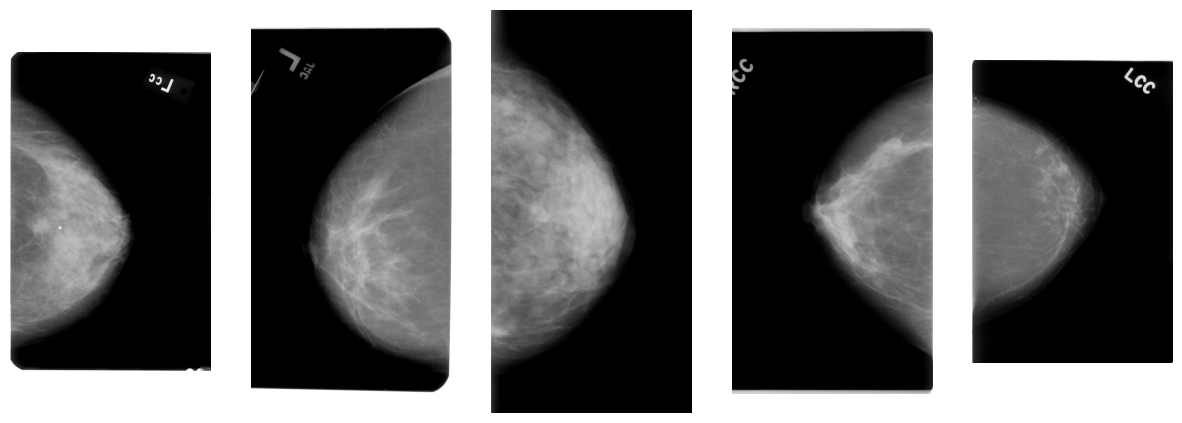

In [33]:
plot_smaples(mass_train_cc['image_file_path'].values, row=15, col=15)


In [34]:
# # given the outputs above the classes are relatively balanced ([296 vs 311 in training] and [67 vs 110 in testing]) 
# # no need of class balancing as of now

# Label Mapping and Verification

# Map pathology to binary labels (malignant = 1, benign and others ( benign_without_callback) = 0)
mass_train_cc['label'] = mass_train_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_cc['label'] = mass_test_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')

# Confirm distribution
print("Training label counts:\n", mass_train_cc['label'].value_counts())
print("Testing label counts:\n", mass_test_cc['label'].value_counts())



Training label counts:
 label
0    311
1    296
Name: count, dtype: int64
Testing label counts:
 label
0    110
1     67
Name: count, dtype: int64


label
0    311
1    296
Name: count, dtype: int64

In [ ]:
# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, seed = 42)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_cc = train_datagen.flow_from_dataframe(
    dataframe=mass_train_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True
)

# Test generator
test_generator_cc = test_datagen.flow_from_dataframe(
    dataframe=mass_test_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

In [ ]:
# # for binary classification 


# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# # Step 1 - Load EfficientNetB0 as the base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Step 2 - Freeze the base model layers
# base_model.trainable = False  # Prevents pretrained weights from being updated

# # Step 3 - Build the classification model
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # Step 4 - Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Step 5 - Summary
# model.summary()


In [ ]:
# # for binary classification 


# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# # Step 1 - Load EfficientNetB0 as the base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Step 2 - Freeze the base model layers
# base_model.trainable = False  # Prevents pretrained weights from being updated

# # Step 3 - Build the classification model
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Binary classification
# ])

# # Step 4 - Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Step 5 - Summary
# model.summary()


In [ ]:
# feature vectors model 

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D




def build_EffB0_feature_extractor_cc(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze last unfreeze_ratio% of layers (same as MLO)
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True
    
    x_cc = GlobalAveragePooling2D()(base_model.output)
    x_cc = Dense(512, activation='relu')(x_cc)
    x_cc =BatchNormalization()(x_cc)
    output = Dropout(0.4)(x_cc)


    # binary classification to check model performance ()
    # x_cc = Dropout(0.4)(x_cc)
    # output = Dense(1, activation='sigmoid')(x_cc)  #Binary classification
    
    return Model(inputs=base_model.input, outputs=output)




# Build model
EffB0_model_cc = build_EffB0_feature_extractor_cc()
EffB0_model_cc.summary()

                              
                             

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     GlobalAveragePooling2D, 
#     Dense, 
#     Dropout, 
#     BatchNormalization,
#     LayerNormalization,
#     Concatenate
# )

# def build_improved_feature_extractor(img_size=(224, 224, 3)):
#     # Base model (EfficientNetB0, frozen)
#     base_model = EfficientNetB0(
#         input_shape=img_size, 
#         include_top=False, 
#         weights='imagenet',
#         pooling=None  # Explicitly no pooling to allow multi-level feature fusion
#     )
#     base_model.trainable = False  # Freeze pretrained weights

#     # Multi-level feature fusion (optional: concat GAP and GMP)
#     gap = GlobalAveragePooling2D()(base_model.output)
#     gmp = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)
#     fused_features = Concatenate()([gap, gmp])  # Combines avg and max pooled features

#     # Non-linear projection head (improves feature separation)
#     x = Dense(1024, activation='relu')(fused_features)
#     x = BatchNormalization()(x)  # Stabilizes training
#     x = Dropout(0.3)(x)
    
#     # L2-normalized output (critical for similarity tasks)
#     output = tf.keras.layers.Lambda(
#         lambda x: tf.math.l2_normalize(x, axis=1)
#     )(x)

#     return Model(inputs=base_model.input, outputs=output)

# # Build and verify
# model = build_improved_feature_extractor()
# model.summary()

In [ ]:
# # for binary classification 
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall, AUC
# import tensorflow_addons as tfa  # For F1 score

# EffB0_model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),
#         tfa.metrics.F1Score(num_classes=1, average='micro', threshold=0.5, name='f1_score')
#     ]
# )


In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall, AUC

# EffB0_model_cc.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),
        
#     ]
# )

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Callbacks to stop training early if val_loss doesn't improve and to save best weights
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_effb0_model.h5', monitor='val_loss', save_best_only=True)

# # Train the model
# history_cc = EffB0_model_cc.fit(
#     train_generator_cc,
#     epochs=12,
#     validation_data=test_generator_cc,
#     callbacks=[early_stop, checkpoint]
# )

In [ ]:
# Just get the features
cc_feature_vectors_train = EffB0_model_cc.predict(train_generator_cc, verbose=1)
cc_feature_vectors_test = EffB0_model_cc.predict(test_generator_cc, verbose=1)


## Evaluate Feature Vectors

# MLO Pathway 

In [37]:
# filter to obtain only the MLO views 

mass_train_mlo = mass_train[mass_train['image_view'] == 'MLO'].copy()
mass_test_mlo = mass_test[mass_test['image_view'] == 'MLO'].copy()

In [38]:
mass_train_mlo.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [39]:
mass_test_mlo.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
5,P_00032,3,RIGHT,MLO,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [ ]:
mass_train_mlo.pathology.value_counts()

In [ ]:
mass_test_mlo.pathology.value_counts()

In [ ]:
# # given the outputs above the classes are relatively balanced ([341 vs 370 in training] and [100 vs 80 in testing]) 
# # no need of class balancing as of now

# Label Mapping and Verification

# Map pathology to binary labels (malignant = 1, benign and others ( benign_without_callback) = 0)
mass_train_mlo['label'] = mass_train_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_mlo['label'] = mass_test_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')

# Confirm distribution
print("Training label counts:\n", mass_train_mlo['label'].value_counts())
print("Testing label counts:\n", mass_test_mlo['label'].value_counts())

In [ ]:
plot_smaples(mass_test_mlo['image_file_path'].values, row=15, col=15)
        

In [ ]:
plot_smaples(mass_train_mlo['image_file_path'].values, row=15, col=15)

In [ ]:
# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, seed = 42)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_mlo = train_datagen.flow_from_dataframe(
    dataframe=mass_train_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = True
)



# Test generator
test_generator_mlo = test_datagen.flow_from_dataframe(
    dataframe=mass_test_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

In [ ]:
def build_EffB0_feature_extractor_mlo(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.models import Model

    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last unfreeze_ratio% of layers
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True

    # Classification head
    x_mlo = GlobalAveragePooling2D()(base_model.output)
    x_mlo = Dense(512, activation='relu')(x_mlo)
    x_mlo =BatchNormalization()(x_mlo)  # Normalizes 512 features
    output = Dropout(0.4)(x_mlo)
    
    
    # binary classification to check model performance ()
    # x_mlo = Dropout(0.4)(x_mlo)
    # output = Dense(1, activation='sigmoid')(x_mlo)  #Binary classification

    return Model(inputs=base_model.input, outputs=output)

# Build model
EffB0_model_mlo = build_EffB0_feature_extractor_mlo()
EffB0_model_mlo.summary()

In [ ]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Precision, Recall, AUC

# EffB0_model_mlo.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         Precision(name='precision'),
#         Recall(name='recall'),
#         AUC(name='auc'),
        
#     ]
# )


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# # Callbacks to stop training early if val_loss doesn't improve and to save best weights
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_effb0_model.h5', monitor='val_loss', save_best_only=True)

# # Train the model
# history_mlo = EffB0_model_mlo.fit(
#     train_generator_mlo,
#     epochs=10,
#     validation_data=test_generator_mlo,
#     callbacks=[early_stop, checkpoint]
# )

In [ ]:
# Just get the features
mlo_feature_vectors_train = EffB0_model_cc.predict(train_generator_cc, verbose=1)
mlo_feature_vectors_test = EffB0_model_cc.predict(test_generator_cc, verbose=1)

# Dual-View Model  Claude


In [ ]:
def build_dual_view_model(img_size=(224, 224, 3), num_classes=1):  # Binary = 1 output
    # Create feature extractors
    cc_extractor = build_EffB0_binary_cc(img_size)
    mlo_extractor = build_EffB0_binary_mlo(img_size)
    
    # Inputs for both views
    cc_input = Input(shape=img_size, name='cc_input')
    mlo_input = Input(shape=img_size, name='mlo_input')
    
    # Extract features from both pathways
    cc_features = cc_extractor(cc_input)
    mlo_features = mlo_extractor(mlo_input)
    
    # Fuse features
    fused_features = Concatenate(name='feature_fusion')([cc_features, mlo_features])
    
    # Classification head
    x = Dense(256, activation='relu')(fused_features)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid', name='prediction')(x)  # Binary classification
    
    # Create the complete model
    dual_model = Model(
        inputs=[cc_input, mlo_input], 
        outputs=output,
        name='dual_view_mammogram_classifier'
    )
    
    return dual_model

In [ ]:
# 3. DATA PREPARATION FOR DUAL-VIEW
def create_paired_dataset(mass_train_cc, mass_train_mlo, mass_test_cc, mass_test_mlo):
    """
    Create paired CC-MLO dataset for dual-view training
    """
    # Merge CC and MLO data on patient_id and breast side
    train_paired = pd.merge(
        mass_train_cc[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        mass_train_mlo[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        on=['patient_id', 'left_or_right_breast'],
        suffixes=('_cc', '_mlo')
    )
    
    test_paired = pd.merge(
        mass_test_cc[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        mass_test_mlo[['patient_id', 'left_or_right_breast', 'cropped_image_file_path', 'label']],
        on=['patient_id', 'left_or_right_breast'],
        suffixes=('_cc', '_mlo')
    )
    
    # Ensure labels match (they should for same patient/breast)
    train_paired = train_paired[train_paired['label_cc'] == train_paired['label_mlo']]
    test_paired = test_paired[test_paired['label_cc'] == test_paired['label_mlo']]
    
    print(f"Paired training samples: {len(train_paired)}")
    print(f"Paired testing samples: {len(test_paired)}")
    
    return train_paired, test_paired


In [ ]:
class DualViewDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paired_df, batch_size=32, img_size=(224, 224), shuffle=True, augment=False):
        self.paired_df = paired_df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.paired_df))
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.paired_df) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.paired_df.iloc[batch_indices]
        
        # Load CC and MLO images
        cc_images = []
        mlo_images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            # Load and preprocess CC image
            cc_img = tf.keras.preprocessing.image.load_img(
                row['cropped_image_file_path_cc'], 
                target_size=self.img_size
            )
            cc_img = tf.keras.preprocessing.image.img_to_array(cc_img) / 255.0
            
            # Load and preprocess MLO image
            mlo_img = tf.keras.preprocessing.image.load_img(
                row['cropped_image_file_path_mlo'], 
                target_size=self.img_size
            )
            mlo_img = tf.keras.preprocessing.image.img_to_array(mlo_img) / 255.0
            
            cc_images.append(cc_img)
            mlo_images.append(mlo_img)
            labels.append(float(row['label_cc']))  # Use either label_cc or label_mlo (they're the same)
        
        return [np.array(cc_images), np.array(mlo_images)], np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


### Training Pipeline 

In [ ]:
class DualViewDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, paired_df, batch_size=32, img_size=(224, 224), shuffle=True, augment=False):
        self.paired_df = paired_df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.paired_df))
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.paired_df) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.paired_df.iloc[batch_indices]
        
        # Load CC and MLO images
        cc_images = []
        mlo_images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            # Load and preprocess CC image
            cc_img = tf.keras.preprocessing.image.load_img(
                row['cropped_image_file_path_cc'], 
                target_size=self.img_size
            )
            cc_img = tf.keras.preprocessing.image.img_to_array(cc_img) / 255.0
            
            # Load and preprocess MLO image
            mlo_img = tf.keras.preprocessing.image.load_img(
                row['cropped_image_file_path_mlo'], 
                target_size=self.img_size
            )
            mlo_img = tf.keras.preprocessing.image.img_to_array(mlo_img) / 255.0
            
            cc_images.append(cc_img)
            mlo_images.append(mlo_img)
            labels.append(float(row['label_cc']))  # Use either label_cc or label_mlo (they're the same)
        
        return [np.array(cc_images), np.array(mlo_images)], np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
def train_dual_view_model():
    # Create paired datasets
    train_paired, test_paired = create_paired_dataset(
        mass_train_cc, mass_train_mlo, mass_test_cc, mass_test_mlo
    )
    
    # Create data generators
    train_generator = DualViewDataGenerator(
        train_paired, 
        batch_size=32, 
        shuffle=True, 
        augment=True
    )
    
    test_generator = DualViewDataGenerator(
        test_paired, 
        batch_size=32, 
        shuffle=False, 
        augment=False
    )
    
    # Build and compile model
    dual_view_model = build_dual_view_model()
    dual_view_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    # Training callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_dual_view_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
    
    # Train the model
    history = dual_view_model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50,
        callbacks=callbacks
    )
    
    return dual_view_model, history    

In [ ]:
# Don't compile individual extractors - just build the dual-view model
print("Building dual-view model...")
dual_view_model = build_dual_view_model()
dual_view_model.summary()

# Train the complete model
# model, history = train_dual_view_model()

# Dual View CHATGPT

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

def build_dual_input_fusion_model(cc_model, mlo_model):
    # Freeze the feature extractor parts of both models
    cc_model.trainable = False
    mlo_model.trainable = False

    # Define separate inputs for CC and MLO images
    input_cc = Input(shape=(224, 224, 3), name='cc_input')
    input_mlo = Input(shape=(224, 224, 3), name='mlo_input')

    # Get the feature vectors from both pathways
    features_cc = cc_model(input_cc)   # shape: (None, 512)
    features_mlo = mlo_model(input_mlo)

    # Concatenate feature vectors
    concatenated = Concatenate()([features_cc, features_mlo])  # shape: (None, 1024)

    # Add classification head
    x = Dense(256, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary output

    # Create model
    fusion_model = Model(inputs=[input_cc, input_mlo], outputs=output, name='EfficientViewNet')

    return fusion_model


In [ ]:
# Assume you have these models from your previous code
# EffB0_model_cc = build_EffB0_binary_cc()
# EffB0_model_mlo = build_EffB0_binary_mlo()

fusion_model = build_dual_input_fusion_model(EffB0_model_cc, EffB0_model_mlo)
fusion_model.summary()


In [ ]:
fusion_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),]
        
)


In [ ]:
history_fusion = fusion_model.fit(


    
)